# Real-Time Optimization
## Modifier Adaptation with Bayesian Optimization using EIC acquisition
### Preliminary thesis results

In [1]:
# Loading the necessary packages
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.utils import Bunch

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.basicConfig(level=logging.ERROR)

from rto.models.williams_otto import WilliamsOttoReactor, WilliamsOttoReactorSimplified
from rto.optimization.optimizer import ModifierAdaptationOptimizer, ModelBasedOptimizer
from rto.optimization.bayesian import ModelBasedBayesianOptimizer
from rto.rto import RTOBayesian, RTO
from rto.adaptation.ma_gaussian_processes import MAGaussianProcesses
from rto.utils import generate_samples_uniform
from rto.experiment.analysis import ExperimentAnalyzer

Creating database to /mnt/d/rto_data/thesis-analysis-03.db


In [2]:
class WilliamsOttoNonConvex(WilliamsOttoReactor):
    def __init__(self):
        super().__init__()
        self.name = 'Williams-Otto (Non-Convex)'

    def get_constraints(self, u, noise=None):
        xa, xb, _, xp, xe, xg = self.solve_steady_state(u)
        g = np.array([xa, xb, xp, xe, xg])
        if(noise != None):
            g = g * (1 + np.random.normal(scale=noise))

        return g

In [3]:
# Our complete model will be called the "plant"
plant = WilliamsOttoReactor()
# And the uncertain is the "model"
model = WilliamsOttoReactorSimplified()
# define the constraints
g0 = 0.012
g1 = 0.08
ubx = [5.5, 100]
lbx = [2.5, 70]
g = np.array([g0, g1])

In [111]:
# Define the input domain
grid_size = 50

u1 = np.linspace(2.5, 6.0, grid_size)
u2 = np.linspace(70, 90, grid_size)
xx, yy = np.meshgrid(u1, u2)

def get_grid_values(model, xx, yy, noise=None):
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost = np.array([model.get_objective(x, noise) for x in grid])
    g = np.array([model.get_constraints(x, noise) for x in grid])
    # reshape the predictions back into a grid
    zz_cost = cost.reshape(xx.shape)
    # zz_g0 = g[:,0].reshape(xx.shape)
    # zz_g1 = g[:,1].reshape(xx.shape)
    zz_g = [g[:,i].reshape(xx.shape) for i in range(g.shape[1])]
    return zz_cost, *zz_g

nc_model = WilliamsOttoReactor()
z_nc = get_grid_values(nc_model, xx, yy)


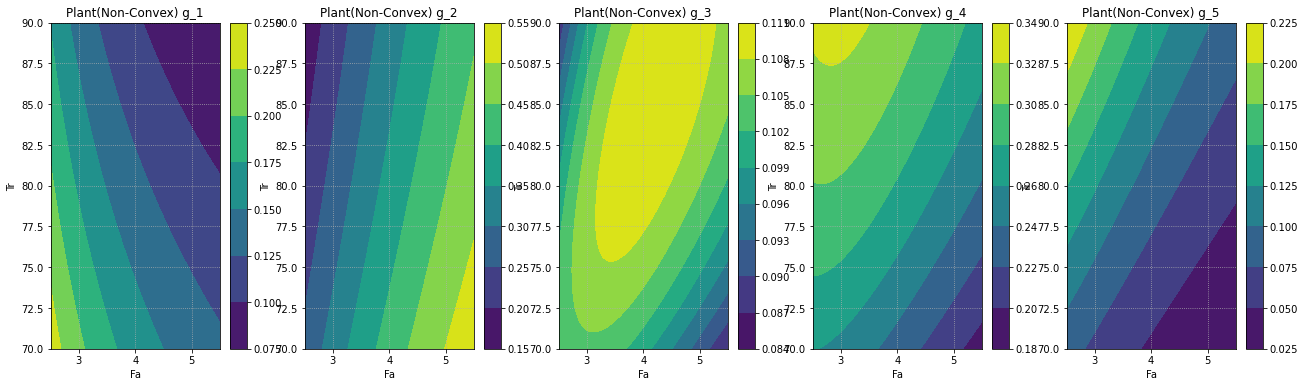

In [39]:
# Plot the decision surface
fig, ax = plt.subplots(1,len(z_nc)-1,figsize=(22,6))
def plot_decision_surface(fig, ax, xx, yy, z_f, z_c, title, contour_type='contourf'):
    if(z_f is not None):
        ax.contour(xx, yy, z_f, colors='red')

    if(contour_type=='contourf'):
        CS = ax.contourf(xx, yy, z_c, cmap='viridis')
    else:
        CS = ax.contour(xx, yy, z_c, cmap='viridis')
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('Fa')
    ax.set_ylabel('Tr')
    ax.set_title(title)

for i in range(1,len(z_nc)):
    plot_decision_surface(fig, ax[i-1], xx, yy, None, z_nc[i], f'Plant(Non-Convex) g_{i}')
fig.show()

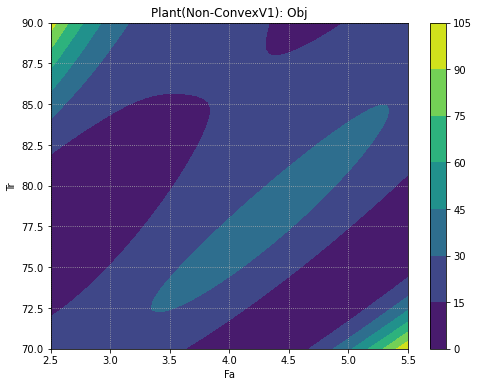

In [64]:
class WilliamsOttoReactor_Branin(WilliamsOttoReactor):
    def __init__(self):
        super().__init__()
        self.name = 'Williams-Otto (Non-Convex)'

    # def get_constraints(self, u, noise=None):
    #     xa, _, _, _, _, xg = self.solve_steady_state(u)
    #     g = np.array([xa, xg])
    #     if(noise != None):
    #         g = g * (1 + np.random.normal(scale=noise))

    #     return g

    def get_objective(self, u, noise=None):
        Fa = 1.8275
        Fb, Tr = u
        _, _, _, xp, xe, _ = self.solve_steady_state(u)
        # adjust inputs to fit in the branin function range
        # −5 ≤ x1 ≤ 10, 0 ≤ x2 ≤ 15.
        # xp: 0.08 - 0.12
        # xe: 0.185 - 0.35
        y, x = 15*(xp - 0.084)/(0.12 - 0.084)-5, 15*(xe - 0.187)/(0.3490 - 0.187)
        fx = float(np.square(y - (4.8/(4*np.square(np.pi)))*np.square(x) + (5/np.pi)*x- 6) + 10*(1-(1./(8*np.pi)))*np.cos(x) + 10)
        return fx if noise == None else fx * (1 + np.random.normal(scale=noise))

nc_model = WilliamsOttoReactor_Branin()
z_nc = get_grid_values(nc_model, xx, yy)
fig, ax = plt.subplots(figsize=(8,6))
plot_decision_surface(fig, ax, xx, yy, None, z_nc[0], f'Plant(Non-ConvexV1): Obj')

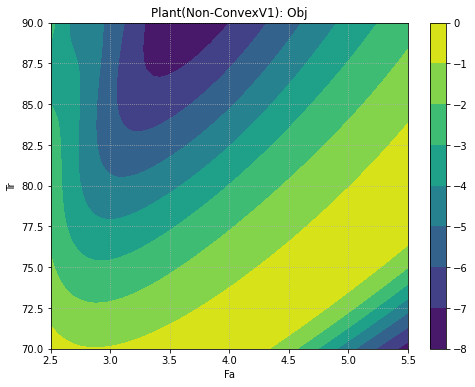

In [168]:
class WilliamsOttoReactor_CamelHump(WilliamsOttoReactor):
    def __init__(self):
        super().__init__()
        self.name = 'Williams-Otto (Non-Convex)'

    def get_objective(self, u, noise=None):
        Fa = 1.8275
        Fb, Tr = u
        _, _, _, xp, xe, _ = self.solve_steady_state(u)
        # xp: 0.08 - 0.12
        # xe: 0.185 - 0.35
        x, y = 5*(xp - 0.084)/(0.12 - 0.084)-2, 5*(xe - 0.187)/(0.3490 - 0.187)-2
        fx = -(2*x**2 - 1.05*x**4 + (1/6)*x**6 + y*x + y**2)
        return fx if noise == None else fx * (1 + np.random.normal(scale=noise))

nc_model = WilliamsOttoReactor_CamelHump()
z_nc = get_grid_values(nc_model, xx, yy)
fig, ax = plt.subplots(figsize=(8,6))
plot_decision_surface(fig, ax, xx, yy, None, z_nc[0], f'Plant(Non-ConvexV1): Obj')

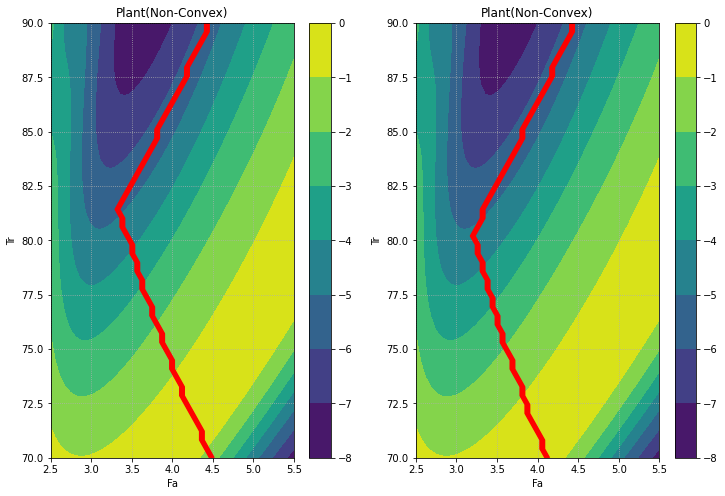

In [170]:
g_nc_1 = (z_nc[2] < 0.12)&(z_nc[1] < 0.15)#&(z_nc[3] > 0.102)&(z_nc[2] < 0.4)
# g_nc_1 = (z_nc[1]**2 > 0.01)&(z_nc[2] < 0.12)
#g_nc_2 = (z_nc[1]**2 > 0.01)&(z_nc[2] < 0.12)
g_nc_2 = (z_nc[2] < 0.12)&(z_nc[1] < 0.16)#&(z_nc[3] > 0.105)&(z_nc[2] < 0.4)

g_nc = g_nc_2 & g_nc_1
fig, ax = plt.subplots(1,2,figsize=(12,8))
plot_decision_surface(fig, ax[0], xx, yy, g_nc_1, z_nc[0], f'Plant(Non-Convex)')
plot_decision_surface(fig, ax[1], xx, yy, g_nc_2, z_nc[0], f'Plant(Non-Convex)')

In [157]:
class WilliamsOttoReactor_CamelHump(WilliamsOttoReactor):
    def __init__(self):
        super().__init__()
        self.name = 'Williams-Otto (Three Camel Hump)'

    def get_objective(self, u, noise=None):
        Fa = 1.8275
        Fb, Tr = u
        _, _, _, xp, xe, _ = self.solve_steady_state(u)
        # xp: 0.08 - 0.12
        # xe: 0.185 - 0.35
        x, y = 5*(xp - 0.084)/(0.12 - 0.084)-2, 5*(xe - 0.187)/(0.3490 - 0.187)-2
        fx = -(2*x**2 - 1.05*x**4 + (1/6)*x**6 + y*x + y**2)
        return fx if noise == None else fx * (1 + np.random.normal(scale=noise))

    
class WilliamsOttoReactor_Branin(WilliamsOttoReactor):
    def __init__(self):
        super().__init__()
        self.name = 'Williams-Otto (Branin)'

    def get_objective(self, u, noise=None):
        Fa = 1.8275
        Fb, Tr = u
        _, _, _, xp, xe, _ = self.solve_steady_state(u)
        # xp: 0.08 - 0.12
        # xe: 0.185 - 0.35
        y, x = 15*(xp - 0.084)/(0.12 - 0.084)-5, 15*(xe - 0.187)/(0.3490 - 0.187)
        fx = float(np.square(y - (4.8/(4*np.square(np.pi)))*np.square(x) + (5/np.pi)*x- 6) + 10*(1-(1./(8*np.pi)))*np.cos(x) + 10)
        return fx if noise == None else fx * (1 + np.random.normal(scale=noise))

class WilliamsOttoReactorSimplified_Branin(WilliamsOttoReactorSimplified):
    def __init__(self):
        super().__init__()
        self.name = 'Williams-Otto Simplified (Branin)'

    def get_objective(self, u, noise=None):
        Fa = 1.8275
        Fb, Tr = u
        _, _, xp, xe, _ = self.solve_steady_state(u)        
        # xp: 0.08 - 0.12
        # xe: 0.185 - 0.35
        y, x = 15*(xp - 0.084)/(0.12 - 0.084)-5, 15*(xe - 0.187)/(0.3490 - 0.187)
        fx = float(np.square(y - (4.8/(4*np.square(np.pi)))*np.square(x) + (5/np.pi)*x- 6) + 10*(1-(1./(8*np.pi)))*np.cos(x) + 10)
        return fx if noise == None else fx * (1 + np.random.normal(scale=noise))

class WilliamsOttoReactorSimplified_CamelHump(WilliamsOttoReactorSimplified):
    def __init__(self):
        super().__init__()
        self.name = 'Williams-Otto Simplified (Three Camel Hump)'

    def get_objective(self, u, noise=None):
        Fa = 1.8275
        Fb, Tr = u
        _, _, xp, xe, _ = self.solve_steady_state(u)
        # xp: 0.08 - 0.12
        # xe: 0.185 - 0.35
        x, y = 5*(xp - 0.084)/(0.12 - 0.084)-2, 5*(xe - 0.187)/(0.3490 - 0.187)-2
        fx = -(2*x**2 - 1.05*x**4 + (1/6)*x**6 + y*x + y**2)
        return fx if noise == None else fx * (1 + np.random.normal(scale=noise))

In [171]:
# solve each non-convex problem
camelhump_plant = WilliamsOttoReactor_CamelHump()
branin_plant = WilliamsOttoReactor_Branin()

camelhump_model = WilliamsOttoReactorSimplified_CamelHump()
branin_model = WilliamsOttoReactorSimplified_Branin()

g_branin = np.array([0.16, 0.12])
g_camelhump = np.array([0.16, 0.12])
ubx = [5.5, 90]
lbx = [2.5, 70]

optimizer_branin = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g_branin)
optimizer_camelhump = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g_camelhump)

f_branin, u_branin ,_ = optimizer_branin.run(branin_plant, [])
f_camelhump, u_camelhump ,_ = optimizer_camelhump.run(camelhump_plant, [])

f_branin_model, u_branin_model ,_ = optimizer_branin.run(branin_model, [])
f_camelhump_model, u_camelhump_model ,_ = optimizer_camelhump.run(camelhump_model, [])

print(f'Branin: u*={u_branin}, f*={f_branin}')
print(f'Camel Hump: u*={u_camelhump}, f*={f_camelhump}')

print(f'Branin (model): u*={u_branin_model}, f*={f_branin_model}')
print(f'Camel Hump (model): u*={u_camelhump_model}, f*={f_camelhump_model}')


Branin: u*=[ 4.36360162 70.71070211], f*=1.9210106809220928
Camel Hump: u*=[ 4.07239401 86.88578441], f*=-5.666724623223295
Branin (model): u*=[ 4.74315578 85.9431246 ], f*=0.3979627734098372
Camel Hump (model): u*=[ 5.49789611 70.00432801], f*=-26.68630137773579


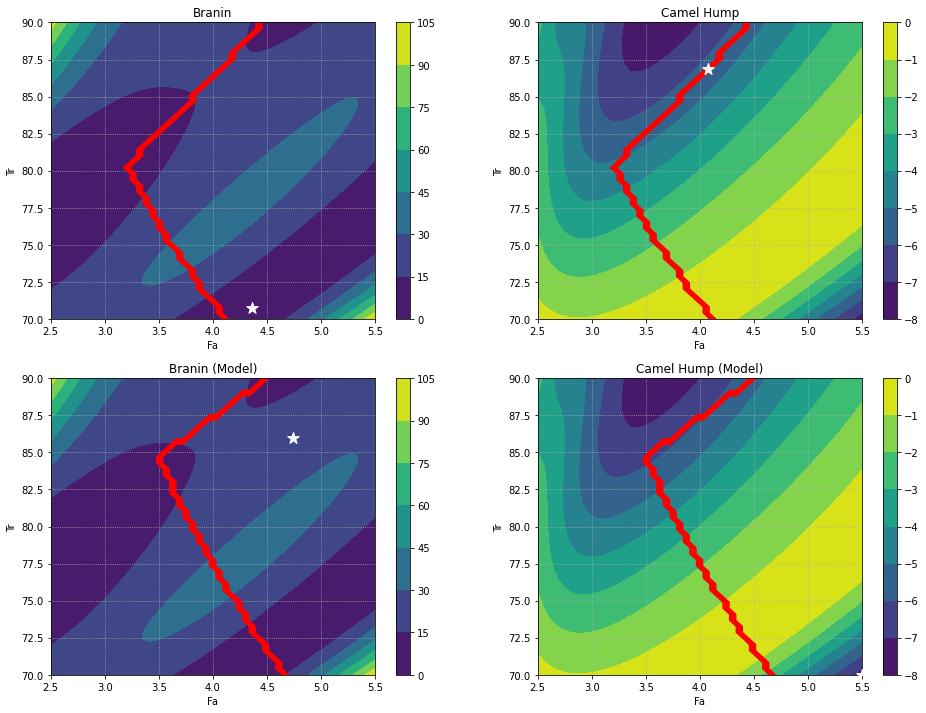

In [172]:
fig, ax = plt.subplots(2,2,figsize=(16,12))

u1 = np.linspace(2.5, 5.5, grid_size)
u2 = np.linspace(70, 90, grid_size)
xx, yy = np.meshgrid(u1, u2)

# generate plant surface data
z_branin, g0_branin, g1_branin = get_grid_values(branin_plant, xx, yy)
z_camelhump, g0_camelhump, g1_camelhump = get_grid_values(camelhump_plant, xx, yy)
g_plant_branin = (g0_branin < g_branin[0])&(g1_branin < g_branin[1])
g_plant_camelhump = (g0_camelhump < g_camelhump[0])&(g1_camelhump < g_camelhump[1])

# generate model surface data
z_branin_model, g0_branin_model, g1_branin_model = get_grid_values(branin_model, xx, yy)
z_camelhump_model, g0_camelhump_model, g1_camelhump_model = get_grid_values(camelhump_model, xx, yy)
g_model_branin = (g0_branin_model < g_branin[0])&(g1_branin_model < g_branin[1])
g_model_camelhump = (g0_camelhump_model < g_camelhump[0])&(g1_camelhump_model < g_camelhump[1])

plot_decision_surface(fig, ax[0,0], xx, yy, g_plant_branin, z_branin, 'Branin')
plot_decision_surface(fig, ax[0,1], xx, yy, g_plant_camelhump, z_camelhump, 'Camel Hump')

plot_decision_surface(fig, ax[1,0], xx, yy, g_model_branin, z_branin, 'Branin (Model)')
plot_decision_surface(fig, ax[1,1], xx, yy, g_model_camelhump, z_camelhump, 'Camel Hump (Model)')

ax[0,0].scatter(u_branin[0], u_branin[1], c='w', marker='*', s=150, zorder=5)
ax[0,1].scatter(u_camelhump[0], u_camelhump[1], c='w', marker='*', s=150, zorder=5)
ax[1,0].scatter(u_branin_model[0], u_branin_model[1], c='w', marker='*', s=150, zorder=5)
ax[1,1].scatter(u_camelhump_model[0], u_camelhump_model[1], c='w', marker='*', s=150, zorder=5)

fig.show()